# Flows conditioned with deep sets

In [2]:
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from flax import linen as nn
import numpy as np
import optax
from neural_flow import Flow
from neural_flow.bijectors import ShiftBounds, RollingSplineCoupling
from neural_flow.utils import FeedForwardNetwork

# We generate some toy data, 1000 sets each with a size drawn from
# an exponential distribution. The maximum size is fixed to 400.
# Each set has elements which are vectors of size two.
rng = np.random.default_rng(1)


def generate(rng, size):
    n = rng.exponential(size=size)
    n *= 400 / np.max(n)
    n += 1  # ensure there are no empty sets
    n = n.astype(int)

    # The mapping to learn is a non-linear function of the inputs. One can also
    # replace np.mean with np.max or np.sum.
    def true_mapping(x):
        return len(x) ** 0.5

    X = [np.array(rng.normal(size=(ni, 2))) for ni in n]
    ym = [true_mapping(x) for x in X]
    y = rng.normal(ym, 1, size=(2, len(ym))).T

    return X, ym, y


def preprocess(X, y, padded_X_size):
    """
    Concatenates the input sets and pads inputs and outputs to fixed sizes.

    Returns padded arrays, the summation matrix, and a mask to undo the padding.
    """
    n = [len(x) for x in X]
    assert padded_X_size >= np.sum(n)
    X = np.concatenate(X)
    X = np.concatenate([X, np.zeros((padded_X_size - len(X),) + X.shape[1:])])
    indices = np.empty((np.sum(n), 2), dtype=int)
    a = 0
    for j, b in enumerate(np.cumsum(n)):
        indices[a:b, 0] = j
        indices[a:b, 1] = np.arange(a, b)
        a = b
    sum_matrix = sparse.BCOO(
        (np.ones(len(indices), dtype=np.int8), indices),
        shape=(len(y), padded_X_size)
    )
    X = jnp.array(X)
    y = jnp.array(y)
    return X, y, sum_matrix


X_train, ym_train, y_train = generate(rng, 1000)
ym_train = jnp.array(ym_train)
X_train, y_train, sum_train = preprocess(X_train, y_train, 50_000)

X_test, ym_test, y_test = generate(rng, 100)
ym_test = jnp.array(ym_test)
X_test, y_test, sum_test = preprocess(X_test, y_test, sum(len(x) for x in X_test))

In [13]:
class DeepSet(nn.Module):
    @nn.compact
    def __call__(self, x, sum_matrix, train: bool):
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = FeedForwardNetwork(8, 6, 128)(x)
        x = nn.Dropout(rate=0.3, deterministic=not train)(x)
        x = sum_matrix @ x
        x = FeedForwardNetwork(1, 6, 128)(x)
        return x.reshape(-1)


deep_set = DeepSet()
root_key = jax.random.PRNGKey(0)
init_key, dropout_key = jax.random.split(root_key)

variables = deep_set.init(init_key, X_train, sum_train, train=False)
params = variables["params"]
batch_stats = variables["batch_stats"]

opt = optax.nadamw(learning_rate=1e-3)
opt_state = opt.init(params)


@jax.jit
def loss_fn(params, batch_stats, x, sum_matrix, y, dropout_key):
    yp, updates = deep_set.apply(
        {"params": params, "batch_stats": batch_stats},
        x,
        sum_matrix,
        train=True,
        mutable=["batch_stats"],
        rngs={"dropout": dropout_key},
    )
    return jnp.mean(optax.l2_loss(yp, y)), updates


@jax.jit
def metric_fn(params, batch_stats, x, sum_matrix, y):
    yp = deep_set.apply(
        {"params": params, "batch_stats": batch_stats}, x, sum_matrix, train=False
    )
    return jnp.mean(optax.l2_loss(yp, y))


@jax.jit
def step(params, batch_stats, opt_state, x, sum_matrix, y, dropout_key):
    grad, updates = jax.grad(loss_fn, has_aux=True)(
        params, batch_stats, x, sum_matrix, y, dropout_key
    )
    batch_stats = updates["batch_stats"]
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, batch_stats, opt_state


best_epoch = 0
best_params = params
loss_train = []
loss_test = []
patience = 100
for epoch in range(5000):
    dropout_train_key = jax.random.fold_in(dropout_key, data=epoch)
    params, batch_stats, opt_state = step(
        params, batch_stats, opt_state, X_train, sum_train, ym_train, dropout_train_key
    )
    loss_train.append(metric_fn(params, batch_stats, X_train, sum_train, ym_train))
    loss_test.append(metric_fn(params, batch_stats, X_test, sum_test, ym_test))
    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_params = params

    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_params = params

    stop = np.isnan(loss_train[-1]) or (
        len(loss_test) > 2 * patience
        and not np.min(loss_test[-patience:])
        < np.min(loss_test[-2 * patience : -patience])
    )

    if epoch % 10 == 0:
        print(
            f"epoch {epoch} loss[train] = {loss_train[-1]:10.2f} "
            f"loss[test] = {loss_test[-1]:10.2f}"
        )

    if stop:
        break

epoch 0 loss[train] =      14.18 loss[test] =      20.61
epoch 10 loss[train] =       2.89 loss[test] =       7.95
epoch 20 loss[train] =       2.66 loss[test] =       7.87
epoch 30 loss[train] =       2.49 loss[test] =       7.22
epoch 40 loss[train] =       3.61 loss[test] =      18.02
epoch 50 loss[train] =       2.18 loss[test] =       5.15
epoch 60 loss[train] =       1.90 loss[test] =       3.64
epoch 70 loss[train] =       1.49 loss[test] =       4.47
epoch 80 loss[train] =       1.78 loss[test] =       2.62
epoch 90 loss[train] =       0.81 loss[test] =       2.88
epoch 100 loss[train] =       3.59 loss[test] =       5.05
epoch 110 loss[train] =       0.95 loss[test] =       2.71
epoch 120 loss[train] =       0.69 loss[test] =       2.04
epoch 130 loss[train] =       0.69 loss[test] =       1.20
epoch 140 loss[train] =       0.59 loss[test] =       0.85
epoch 150 loss[train] =       0.20 loss[test] =       0.60
epoch 160 loss[train] =       0.18 loss[test] =       0.35
epoch 17

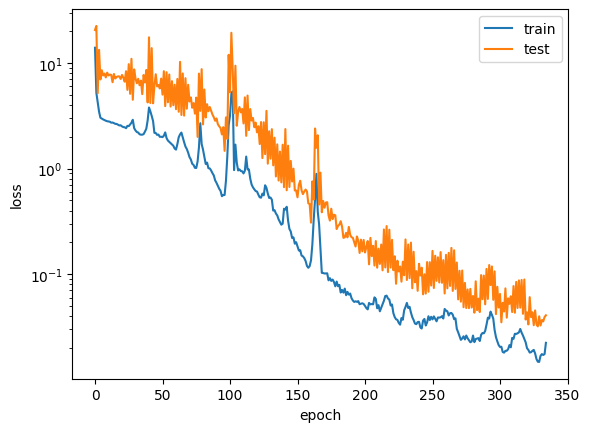

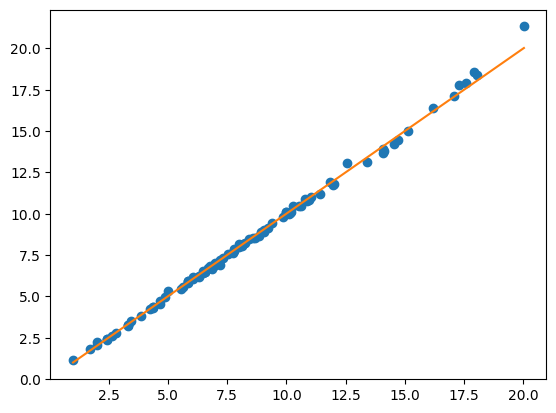

In [10]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.semilogy()

plt.figure()
ym_pred = deep_set.apply(
    {"params": best_params, "batch_stats": batch_stats}, X_test, sum_test, train=False
)
plt.scatter(ym_test, ym_pred)
diag = [np.min(ym_test), np.max(ym_test)]
plt.plot(diag, diag, color="C1");

In [28]:
flow = Flow(
    ShiftBounds(),
    RollingSplineCoupling(
        knots=16, make_network=lambda n: FeedForwardNetwork(n, 2, 128)
    ),
)


class Phi(nn.Module):
    @nn.compact
    def __call__(self, x, sum_matrix, train: bool):
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = FeedForwardNetwork(8, 6, 128)(x)
        x = nn.Dropout(rate=0.3, deterministic=not train)(x)
        x = sum_matrix @ x
        x = nn.Dense(1)(x)
        return x


phi = Phi()
variables = phi.init(init_key, X_train, sum_train, train=False)
batch_stats = variables["batch_stats"]

# c_init = phi.apply(variables, X_train, sum_train, train=False)
params = {
    "phi": variables["params"],
    "flow": flow.init(init_key, y_train, ym_train)
}


@jax.jit
def loss_fn_2(params, batch_stats, y, x, sum_matrix, dropout_key):
    c, updates = phi.apply(
        {"params": params["phi"], "batch_stats": batch_stats},
        x,
        sum_matrix,
        train=True,
        mutable=["batch_stats"],
        rngs={"dropout": dropout_key},
    )
    return -np.mean(flow.log_prob(params["flow"], y, c)), updates


@jax.jit
def metric_fn_2(params, batch_stats, y, x, sum_matrix):
    c = phi.apply(
        {"params": params["phi"], "batch_stats": batch_stats},
        x,
        sum_matrix,
        train=False,
    )
    return -np.mean(flow.log_prob(params["flow"], y, c))


opt = optax.nadamw(learning_rate=1e-3)
opt_state = opt.init(params)


@jax.jit
def step(params, batch_stats, opt_state, y, x, sum_matrix, dropout_key):
    grad, updates = jax.grad(loss_fn_2, has_aux=True)(
        params, batch_stats, y, x, sum_matrix, dropout_key
    )
    batch_stats = updates["batch_stats"]
    updates, opt_state = opt.update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, batch_stats


best_epoch = 0
best_params = params
loss_train = []
loss_test = []
patience = 100
for epoch in range(5000):
    dropout_train_key = jax.random.fold_in(dropout_key, epoch)
    params, opt_state, batch_stats = step(
        params, batch_stats, opt_state, y_train, X_train, sum_train, dropout_train_key
    )
    loss_train.append(metric_fn_2(params, batch_stats, y_train, X_train, sum_train))
    loss_test.append(metric_fn_2(params, batch_stats, y_test, X_test, sum_test))
    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_params = params

    if loss_test[-1] < loss_test[best_epoch]:
        best_epoch = epoch
        best_params = params

    stop = np.isnan(loss_train[-1]) or not np.isfinite(loss_train[-1]) or (
        len(loss_test) > 2 * patience
        and not np.min(loss_test[-patience:])
        < np.min(loss_test[-2 * patience : -patience])
    )

    print(f"epoch {epoch} {loss_train[-1]:.2f} {loss_test[-1]:.2f}")

    if stop:
        break

epoch 0 12.73 19.99
epoch 1 7.79 7.60
epoch 2 7.21 7.25
epoch 3 8.39 8.09
epoch 4 6.83 7.01
epoch 5 6.69 6.98
epoch 6 6.81 7.05
epoch 7 6.57 6.87
epoch 8 6.41 6.56
epoch 9 6.30 6.48
epoch 10 6.26 6.41
epoch 11 6.10 6.28
epoch 12 6.04 6.36
epoch 13 6.02 6.41
epoch 14 5.94 6.28
epoch 15 5.82 6.08
epoch 16 5.74 6.01
epoch 17 5.67 6.04
epoch 18 5.60 5.89
epoch 19 5.52 5.84
epoch 20 5.47 5.73
epoch 21 5.38 5.71
epoch 22 5.26 5.72
epoch 23 5.17 5.65
epoch 24 5.29 5.79
epoch 25 5.05 5.39
epoch 26 5.08 5.29
epoch 27 5.13 5.47
epoch 28 5.26 5.68
epoch 29 5.17 5.47
epoch 30 5.07 5.40
epoch 31 4.91 5.17
epoch 32 4.83 5.04
epoch 33 4.90 5.01
epoch 34 4.75 4.84
epoch 35 4.74 4.81
epoch 36 4.72 4.70
epoch 37 4.85 5.05
epoch 38 4.74 4.91
epoch 39 4.64 4.65
epoch 40 4.99 5.70
epoch 41 4.68 4.80
epoch 42 4.65 4.73
epoch 43 4.63 4.58
epoch 44 4.61 4.54
epoch 45 4.44 4.54
epoch 46 4.44 4.80
epoch 47 4.35 4.53
epoch 48 4.39 4.72
epoch 49 4.22 4.48
epoch 50 4.38 4.48
epoch 51 4.65 5.15
epoch 52 4.40 4.56
e

KeyboardInterrupt: 

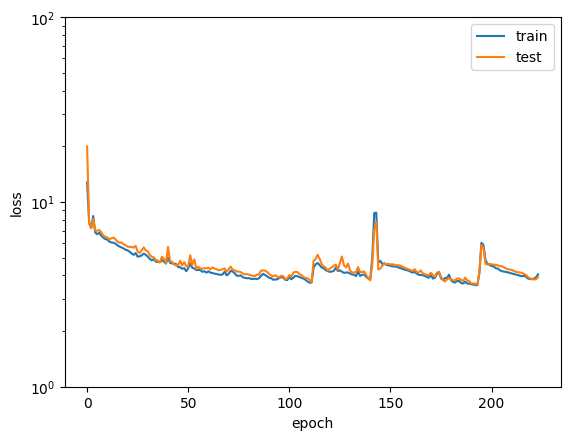

In [30]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(loss_train, label="train")
plt.plot(loss_test, label="test")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1, 1e2)
plt.semilogy();

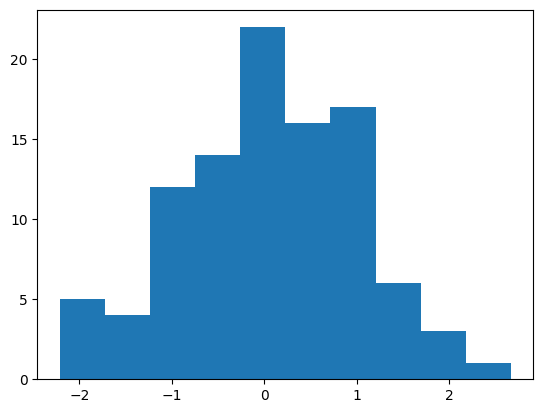

In [ ]:
plt.hist(y_test[:, 0] - np.array(ym_test));

(array([ 1.,  3.,  7., 16., 33., 22.,  3.,  4.,  7.,  4.]),
 array([-13.11829567, -10.10384369,  -7.08939219,  -4.0749402 ,
         -1.06048846,   1.95396328,   4.96841526,   7.98286676,
         10.99731827,  14.01177025,  17.02622223]),
 <BarContainer object of 10 artists>)

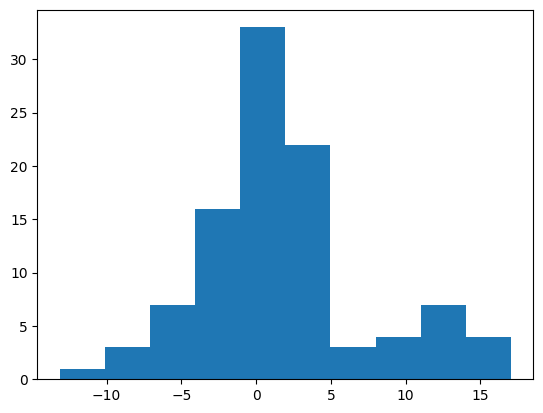

In [31]:
c = phi.apply(
    {"params": params["phi"], "batch_stats": batch_stats}, X_test, sum_test, train=False
)
y_pred = flow.sample(params["flow"], c)
plt.hist(y_pred[:, 0] - np.array(ym_test));